### Описание проекта

**Дано**:
Несколько датасетов, каждый из 2000 изображений и соответствующих масок.
Датасет составлен из изображений растений, вид сверху. В датасете представлены разные растения, в начальной стадии развития. Датасет состоит как из дневных (RGB), так и ночных (grayscale) снимков.
Варианты датасетов:
1. Все культуры, дневные и ночные снимки
2. Все культуры, только дневные снимки
3. Все культуры, только ночные снимки
4. Культры по отдельности - дневные и ночные снимки
5. Культуры по отдельности - дневные снимки
5. Культуры по отдельности - ночные снимки

**Задача**:
Провести исследования:
1. Какая модель будет лучше работать на общем датасете
2. Будет ли эта модель показывать лучшие результаты, если тренировать ее (и тестировать) отдельно на дневных, и отдельно на ночных снимках
3. Будет ли это модель показывать лучшие результаты, если тренировать ее отдельно каждой культуре (и тестировать на соответствующих культурах).

**Цели**:
1. Получить таблицу со сводными данными по каждому исследованию.
2. Получить тренированную модель/серию моделей, готовых к работе на новых данных.

**План действий**
1. Загрузить датасет
2. Вывести случайные изображения и маски
3. Определить стратегии аугментации
4. Вывести изображения и маски с аугментациями (для контроля и наглядности)
5. Загрузка модели Unet с Resnet энкодером, тренированной на ImageNet
6. Тренировка на всех датасетах
7. Вывод примеров предсказаний
9. Сравнение

### 1. Сравнение разных backbone-ов на общем датасете

#### Все импорты

In [13]:
import os
from PIL import Image
import numpy as np
import cv2
import random
import torch
import torchvision
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score # оценка сегментации

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from segmentation_models_pytorch import Unet

In [6]:
print(torch.__version__)
print(np.__version__)

2.2.2
1.26.4


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### Доп. методы для вывода изображений и масок

In [8]:
def show_images_and_masks(images, masks, names=None):
    '''
    Метод для вывода в output изображений и масок.
    images: list(PIL Image, torch.Tensor, torchvision.tv_tensors._image.Image)
    masks: list(PIL Image, torch.Tensor, torchvision.tv_tensors._mask.Mask)
    '''
    num_examples = len(images)
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

    if num_examples == 1:
        axes = np.expand_dims(axes, axis=-1)  # Расширение размерности для корректного индексации если только 1 пара изображение+маска

    for i in range(num_examples):
        # Загрузка изображения
        img = images[i]
        if type(img) in [torchvision.tv_tensors._image.Image, torchvision.tv_tensors._mask.Mask, torch.Tensor]:
          img = img.permute(1, 2, 0)
          # img = img.numpy()
          # img = (img - img.min()) / (img.max() - img.min())

        # Загрузка маски
        mask = masks[i]
        if type(mask) in [torchvision.tv_tensors._image.Image, torchvision.tv_tensors._mask.Mask, torch.Tensor]:
          mask = mask.permute(1, 2, 0)

        # Отображение изображения
        axes[0, i].imshow(img)
        if names:
            axes[0, i].set_title(f"{names[i]} (image)")
        else:
            axes[0, i].set_title(f"Image {i+1}")
        axes[0, i].axis("off")

        # Отображение маски
        axes[1, i].imshow(mask, cmap="gray")
        if names:
            axes[1, i].set_title(f"{names[i]} (mask)")
        else:
            axes[1, i].set_title(f"Image {i+1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Показать изображения и маски по адресам на диске
def show_images_and_masks_by_paths(images_paths, masks_paths):
  images = [Image.open(os.path.join(image_path)) for image_path in images_paths]
  masks = [Image.open(os.path.join(mask_path)) for mask_path in masks_paths]
  show_images_and_masks(images, masks)

# Показать случайные n изображений и масок
def show_random_images_and_masks(images_path, masks_path, num_examples=5):
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    random_numbers = [int(random.random()*len(image_files)) for _ in range(num_examples)]

    image_files = [os.path.join(images_path, image_files[n]) for n in random_numbers]
    mask_files = [os.path.join(masks_path, mask_files[n]) for n in random_numbers]
    show_images_and_masks_by_paths(image_files, mask_files)

def overlay_mask_on_image(image, mask, alpha=0.5, mask_color=[1, 0, 0]):
    """
    Накладывает сегментационную маску на изображение с заданной прозрачностью.

    :param image: Исходное изображение в формате NumPy
    :param mask: Сегментационная маска в формате NumPy (0 и 255)
    :param alpha: Прозрачность маски (0.0 - полностью прозрачная, 1.0 - полностью непрозрачная)
    :param mask_color: Цвет маски (по умолчанию красный) в формате [R, G, B]
    """
    # Нормализуем изображение и маску
    image = image / 255.0
    mask = mask / 255.0
    
    # Создаем цветную маску
    color_mask = np.zeros_like(image)
    for i in range(3):
        color_mask[..., i] = mask * mask_color[i]

    # Накладываем маску на изображение
    overlay_image = image * (1 - alpha) + color_mask * alpha

    return overlay_image

def display_images_side_by_side(images, titles=None, max_images_per_row=4):
    num_images = len(images)
    
    if num_images == 0:
        print("Нет изображений для отображения.")
        return
    
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # округление вверх
    num_cols = min(num_images, max_images_per_row)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = np.array([[ax] for ax in axes])
    
    axes = axes.reshape(num_rows, num_cols)
    
    for i, (ax, image) in enumerate(zip(axes.flat, images)):
        if image.ndim == 2:  # grayscale image
            ax.imshow(image, cmap='gray')
        else:  # RGB image
            ax.imshow(image)
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
    
    # Удаление лишних осей
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])
    
    plt.tight_layout()
    plt.show()

### Адрес датасета на диске

In [9]:
# Пути к папкам с изображениями и масками
path_to_datasets = "../datasets/"
dataset_name = "All Cultures Day And Night"
images_dir_path = os.path.join(path_to_datasets, dataset_name, "originals")
masks_dir_path = os.path.join(path_to_datasets, dataset_name, "masks")

images_paths = [os.path.join(images_dir_path, file_name) for file_name in sorted(os.listdir(images_dir_path))]
masks_paths = [os.path.join(masks_dir_path, file_name) for file_name in sorted(os.listdir(masks_dir_path))]
print(f"Images: {len(images_paths)}")
print(f"Masks: {len(masks_paths)}")

Images: 1998
Masks: 1998


In [3]:
# show_random_images_and_masks(images_dir_path, masks_dir_path, 3)

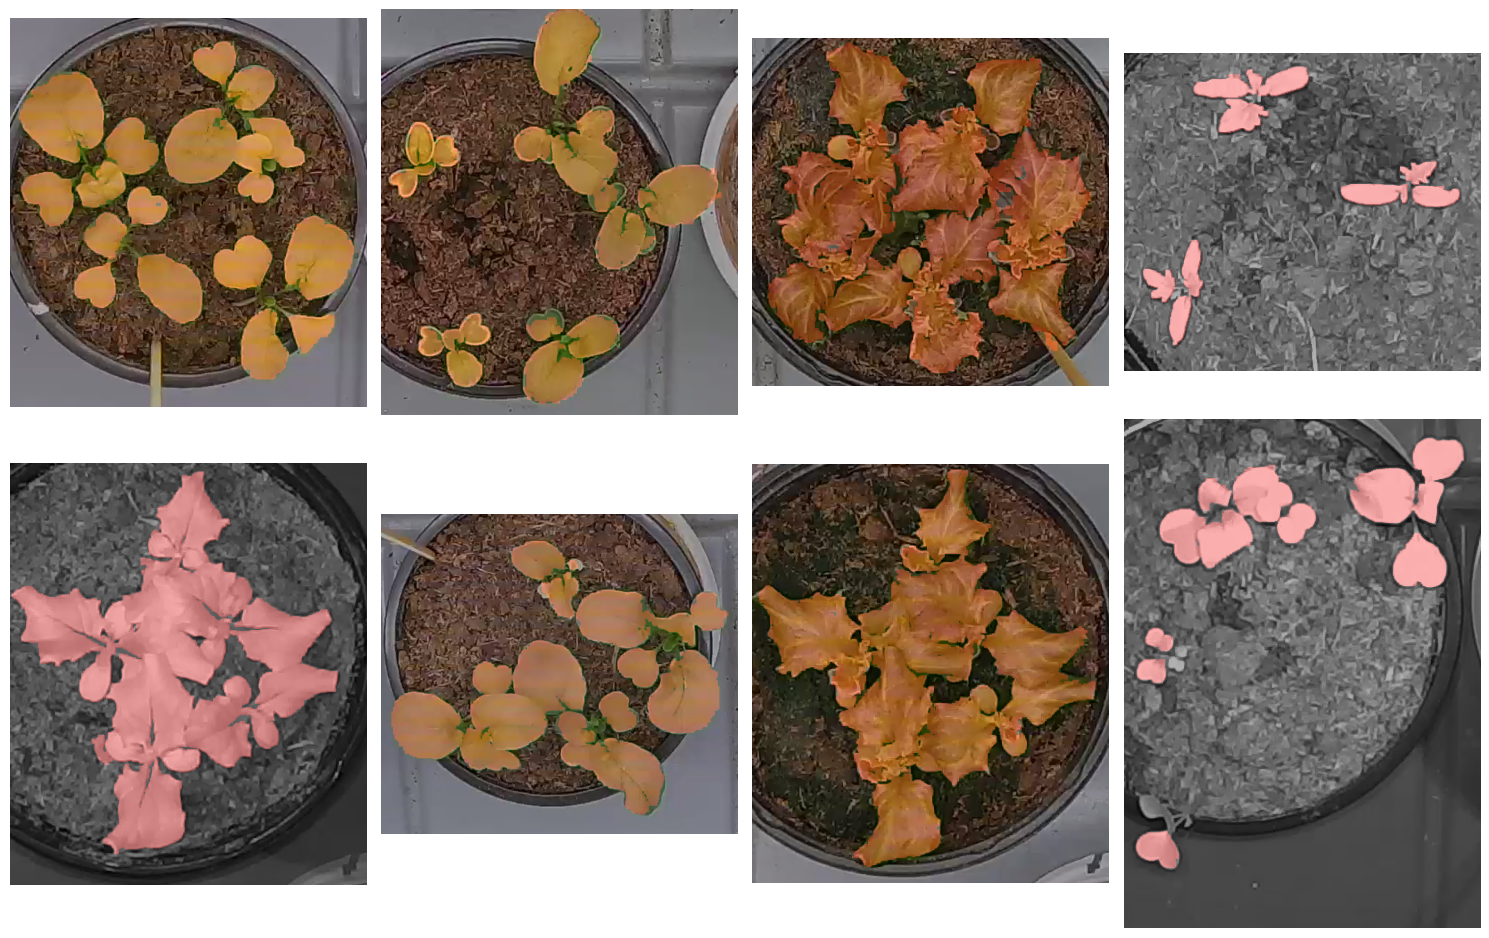

In [16]:
num_of_samples = 8
random_images_num = np.random.choice(len(images_paths), num_of_samples, replace=False)

overlayed_images = []
for num in random_images_num:
    image = cv2.cvtColor(cv2.imread(images_paths[num]), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths[num], cv2.IMREAD_GRAYSCALE)

    overlayed_images.append(overlay_mask_on_image(image, mask, alpha=.3, mask_color=[1,0,0]))

display_images_side_by_side(overlayed_images)

#### Определяем стратегии тренировок - модели, водные размеры изображений и т.д.

In [17]:
strategies = [
    {
        "name"          : "resnet34_256_256",
        "encoder"       : "resnet34",
        "image_size"    : (256, 256),
        "grayscale"     : False,
        "description"   : "ResNet34, Image size: 256x256",
        "dataset"       : {
            "name"  : "All Cultures Day And Night",
            "train" : None,
            "val"   : None
        },
        "model_config"  : {
            "name"     : None,
            "model" : None,
            "optimizer" : None,
            "dataloader" : {
                "train" : None,
                "val"   : None
            },
            "history" : None
        }
    },
    {
        "name"          : "resnet34_512_512",
        "encoder"       : "resnet34",
        "image_size"    : (512, 512),
        "grayscale"     : False,
        "description"   : "ResNet34, Image size: 512x512",
        "dataset"       : {
            "name"  : "All Cultures Day And Night",
            "train" : None,
            "val"   : None
        },
        "model_config"  : {
            "name"     : None,
            "model" : None,
            "optimizer" : None,
            "dataloader" : {
                "train" : None,
                "val"   : None
            },
            "history" : None
        }
    }
]

### Класс датасета

In [18]:
class SegmentationDataset(Dataset):
  def __init__(self, images_paths, masks_paths, size=(256, 256), grayscale=False, transform=None):
    self.images_paths = images_paths
    self.masks_paths = masks_paths
    self.grayscale = grayscale
    self.size = size
    self.transform = transform

  def __len__(self):
    return len(self.images_paths)

  def __getitem__(self, idx):
    image = Image.open(self.images_paths[idx]).convert("RGB") if not self.grayscale else Image.open(self.images_paths[idx]).convert("L")
    mask = Image.open(self.masks_paths[idx]).convert("L")

    # к тензорам
    image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)
    mask = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=False)])(mask)

    # приводим маску к 0 и 1 и делаем ее tv_tensor.Mask
    mask = (mask > 0).float() # приводим к 0 и 1 (в масках могут быть косяки, т.е. значения отличные от 0 и 255)
    mask = tv_tensors.Mask(mask)

    #  изменение размера
    image, mask = v2.Resize(self.size)(image, mask)

    # преобразования
    if self.transform:
        image, mask = self.transform(image, mask)

    # нормализация изображения
    image = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

    return image, mask
  
  
  def convert_image_to_input_format(self, image):
    """
    Принимает numpy или PIL изображение, возвращает тензор, готовый к загрузке в модель
    """
    image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)
    image = v2.Resize(self.size)(image)
    image = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    image = image.unsqueeze(0).to(device) # добавляем размерность батча
    return image
  
  def resize_prediction_to_original(self, prediction_tensor, original_size):
    """
    Масштабирует тензор предсказаний до исходного размера и возвращает изображение в формате NumPy.
    
    :param prediction_tensor: Тензор предсказаний модели (C, H, W)
    :param original_size: Исходный размер изображения (width, height)
    :return: Изображение в формате NumPy, растянутое до исходного размера
    """
    prediction_tensor = prediction_tensor.cpu()
    prediction_image = v2.ToPILImage()(prediction_tensor)

    resized_prediction_image = v2.Resize(original_size)(prediction_image)
    prediction_numpy = np.array(resized_prediction_image)

    return prediction_numpy


#### Разбиение данных на train и test

In [19]:
images_train, images_test, masks_train, masks_test = train_test_split(images_paths, masks_paths, test_size=0.15, random_state=42)

#### Создание датасетов и моделей по заданным стратегиям

In [20]:
for strategie in strategies:
  strategie['dataset']['train'] = SegmentationDataset(images_train, masks_train, size=strategie['image_size'], grayscale=strategie['grayscale'])
  strategie['dataset']['val'] = SegmentationDataset(images_test, masks_test, size=strategie['image_size'], grayscale=strategie['grayscale'])
  in_channel = 1 if strategie['grayscale'] else 3
  strategie['model_config']['name'] = f"Unet_{strategie['name']}_{strategie['dataset']['name'].lower().replace(' ', '_')}"
  strategie['model_config']['model'] = Unet(encoder_name=strategie['encoder'], encoder_weights='imagenet', in_channels=in_channel, classes=1).to(device)
  strategie['model_config']['optimizer'] = torch.optim.Adam(strategie['model_config']['model'].parameters(), lr=1e-4)
  strategie['model_config']['dataloader']['train']  = DataLoader(strategie['dataset']['train'], batch_size=16, shuffle=True)
  strategie['model_config']['dataloader']['val'] = DataLoader(strategie['dataset']['val'], batch_size=16, shuffle=False)
  print(f"Model {strategie['model_config']['name']} created")


Model Unet_resnet34_256_256_all_cultures_day_and_night created
Model Unet_resnet34_512_512_all_cultures_day_and_night created


##### Методы тренировки и оценки моделей

In [21]:
# Для оценки точности модели сегментации используем метрику Intersection over Union (IoU) (Jaccard Index)
def calculate_iou(predictions, targets, threshold=0.5):
    preds = (predictions >= threshold).astype(np.uint8)
    targets = targets.astype(np.uint8)
    iou = jaccard_score(targets.flatten(), preds.flatten())
    return iou

In [22]:
# Функция обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        # for images, masks in train_loader:
        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate IoU for the batch
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            batch_iou = calculate_iou(preds, masks)
            running_iou += batch_iou

        avg_train_loss = running_loss / len(train_loader)
        avg_train_iou = running_iou / len(train_loader)

        val_loss = 0.0
        val_iou = 0.0

        model.eval()

        val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", leave=False)

        with torch.no_grad():
            # for images, masks in val_loader:
            for images, masks in val_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate IoU for the batch
                preds = torch.sigmoid(outputs).detach().cpu().numpy()
                masks = masks.detach().cpu().numpy()
                batch_iou = calculate_iou(preds, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}')

        history['train_loss'].append(avg_train_loss)
        history['train_iou'].append(avg_train_iou)
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)

    return history

### Тренировка и сохранение результатов


#### Куда сохранять

In [14]:
# google colab + google drive
# models_dir_path = "/content/drive/MyDrive/_STUDY/Computer Vision/OTUS - Computer Vision Pro/_Course Project/1 - Train Segmentation Model/models/"

# local
models_dir_path = "../models/"
print(f"Models dir exists : {os.path.exists(models_dir_path)}")

Models dir exists : True


#### Как сохранять

In [15]:
def save_model_config(model_config):
  model_path = os.path.join(models_dir_path, f"{model_config['name']}.pth")

  torch.save({
      "model_state_dict"     : model_config["model"].state_dict(),
      "optimizer_state_dict" : model_config["optimizer"].state_dict(),
      "history"              : model_config["history"]
  }, model_path)

####  Тренировка!

##### Все модели по очереди...

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
for strategie in strategies:
  print(f"----------------------------------{strategie['model_config']['name']}----------------------------------")

  model = strategie['model_config']['model']
  train_dataloader = strategie['model_config']['dataloader']['train']
  val_dataloader = strategie['model_config']['dataloader']['val']
  optimizer = strategie['model_config']['optimizer']

  # погнали!
  history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer)
  strategie['model_config']['history'] = history

  save_model_config(strategie['model_config'])

----------------------------------Unet_resnet34_512_512_all_cultures_day_and_night----------------------------------


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/107 [00:00<?, ?it/s]

##### ... или одну конкретную

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

strategie_num = 1
strategie = strategies[strategie_num]
print(f"----------------------------------{strategies[strategie_num]['model_config']['name']}----------------------------------")

model = strategie['model_config']['model']
train_dataloader = strategie['model_config']['dataloader']['train']
val_dataloader = strategie['model_config']['dataloader']['val']
optimizer = strategie['model_config']['optimizer']

# погнали!
history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer)
strategie['model_config']['history'] = history

save_model_config(strategie['model_config'])

### Загрузка моделей из файлов (если уже тренировались, но, допустим, слетела среда)

In [16]:
def load_model_config(model_config):
    model_path = os.path.join(models_dir_path, f"{model_config['name']}.pth")

    # Загрузка состояния
    try:
        checkpoint = torch.load(model_path, map_location=device)
        
        # Восстановление состояния модели
        model_config["model"].load_state_dict(checkpoint["model_state_dict"])
        model_config["optimizer"].load_state_dict(checkpoint["optimizer_state_dict"])
        model_config["history"] = checkpoint["history"]

        model_config["model"].eval()

        print(f"Модель удачно загружена: {model_config['name']}")
        return model_config
    
    except FileNotFoundError as e:
        print(f"Не удалось загрузить модель: {model_config['name']}")
        print(f"(Ошибка: {e})")


In [17]:
# for model_config in tqdm(model_configs):
for strategie in strategies:
  load_model_config(strategie['model_config'])

Модель удачно загружена: Unet_resnet34_256_256_all_cultures_day_and_night
Не удалось загрузить модель: Unet_resnet34_512_512_all_cultures_day_and_night
(Ошибка: [Errno 2] No such file or directory: '../models/Unet_resnet34_512_512_all_cultures_day_and_night.pth')


### Визуализация результатов

#### Визуализация графиков loss и accurancy моделей

In [18]:
def plot_model_histories(model_configs):
    # Проверка, если передана одна модель
    if isinstance(model_configs, dict):
        model_configs = [model_configs]

    plt.figure(figsize=(12, 6))

    # График val_loss
    plt.subplot(1, 2, 1)
    for config in model_configs:
        epochs = range(1, len(config['history']['val_loss']) + 1)
        plt.plot(epochs, config['history']['val_loss'], label=f"{config['name']}")
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График val_iou
    plt.subplot(1, 2, 2)
    for config in model_configs:
        epochs = range(1, len(config['history']['val_iou']) + 1)
        plt.plot(epochs, config['history']['val_iou'], label=f"{config['name']}")
    plt.title('Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

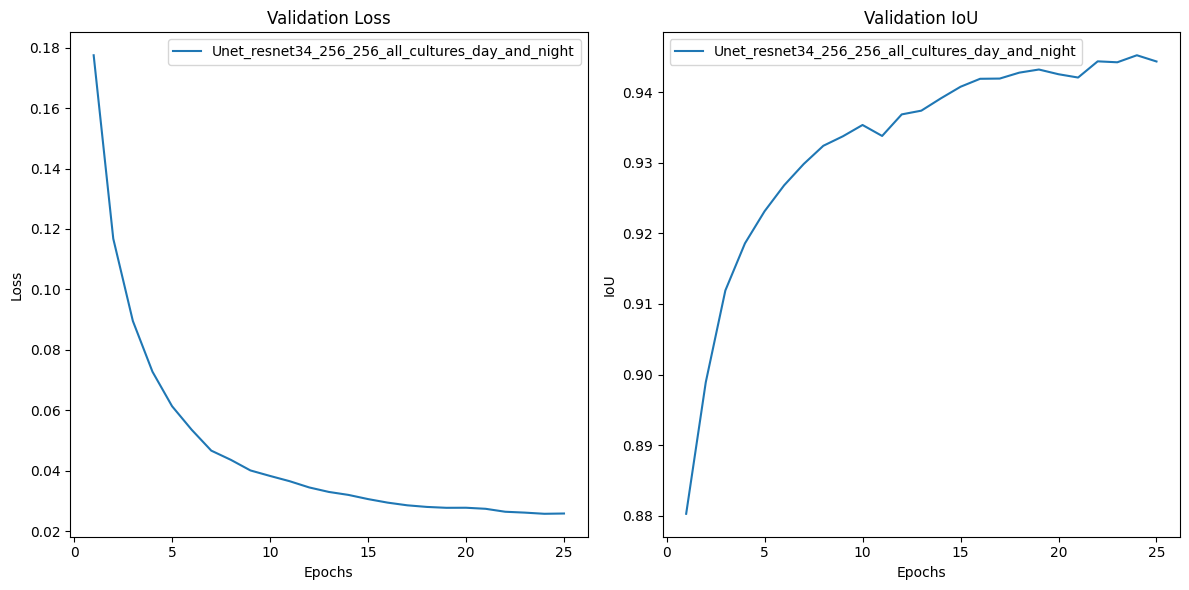

In [19]:
model_configs = [strategie['model_config'] for strategie in strategies]
plot_model_histories(model_configs[0])

#### Визуализация предсказаний

In [20]:
def overlay_mask_on_image(image, mask, alpha=0.4, mask_color=[1, 0, 1]):
    """
    Накладывает сегментационную маску на изображение с заданной прозрачностью.

    :param image: Исходное изображение в формате NumPy
    :param mask: Сегментационная маска в формате NumPy (0 и 255)
    :param alpha: Прозрачность маски (0.0 - полностью прозрачная, 1.0 - полностью непрозрачная)
    :param mask_color: Цвет маски (по умолчанию красный) в формате [R, G, B]
    """
    # Нормализуем изображение и маску
    # image = image / 255.0
    # mask = mask / 255.0
    
    # Создаем цветную маску
    color_mask = np.zeros_like(image)
    for i in range(3):
        color_mask[..., i] = mask * mask_color[i]

    # Накладываем маску на изображение
    overlay_image = image * (1 - alpha) + color_mask * alpha

    return overlay_image

In [21]:
def visualize_results(model_configs, val_loader, n=3, overlay=False):
    """
    overlay: выводить маски поверх оригинального изображения
    """
    if isinstance(model_configs, dict):
        model_configs = [model_configs]

    for config in model_configs:
        config["model"].eval()

    # Выбор n случайных примеров
    val_loader_iter = iter(val_loader)
    total_samples = len(val_loader.dataset)
    indices = random.sample(range(total_samples), n)

    for idx in indices:
        images, masks = val_loader.dataset[idx]
        images = images.unsqueeze(0).to(device)  # Добавляем размерность батча
        masks = masks.unsqueeze(0)

        plt.figure(figsize=(15, 5))

          # Подготовка входного изображения
        image_np = images[0].permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Отображаем входное изображение и маску
        plt.subplot(1, len(model_configs) + 2, 1)
        plt.imshow(image_np)
        plt.title('Input Image')
        plt.axis('off')

        mask_np = masks[0].permute(1, 2, 0).cpu().numpy() * 255
        plt.subplot(1, len(model_configs) + 2, 2)
        if overlay:
            plt.imshow(overlay_mask_on_image(image_np, mask_np.squeeze()))
        else:
            plt.imshow(mask_np, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Отображаем предсказания каждой модели
        for i, config in enumerate(model_configs):
            print(f"Предсказываем семпл {idx} моделью {i}")
            model = config["model"]
            with torch.no_grad():
                outputs = model(images)
                preds = torch.sigmoid(outputs).round()

            pred_mask_np = preds[0].permute(1, 2, 0).cpu().numpy() * 255
            plt.subplot(1, len(model_configs) + 2, i + 3)
            if overlay:
                plt.imshow(overlay_mask_on_image(image_np, pred_mask_np.squeeze()))
            else:
                plt.imshow(pred_mask_np, cmap='gray')
            plt.title(config['name'], fontsize=7)
            plt.axis('off')

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..102.56871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..102.55865].


Предсказываем семпл 242 моделью 0


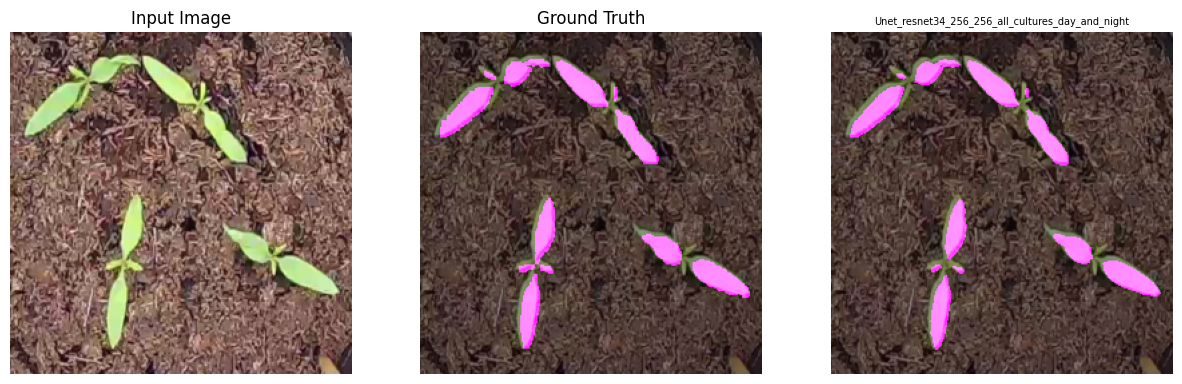

In [23]:
visualize_results(model_configs[0], val_loader=model_configs[0]['dataloader']['val'], n=1, overlay=True)

### Сравнение результатов

In [ ]:
import pandas as pd
from IPython.display import display, HTML

In [ ]:
# Компоновка данных для итоговой таблицы
def extract_data(model_configs):
    extracted_data = []
    for item in model_configs:
        compose = item['train_dataset']['transform_strategie']['transform']
        transform_list = [str(t) for t in compose.transforms] if compose else None
        extracted_data.append({
            'strategy_name': item['train_dataset']['transform_strategie']['name'],
            'strategy_description': item['train_dataset']['transform_strategie']['description'],
            'transforms': '<br>'.join(transform_list) if transform_list else None,
            'last_train_loss': item['history']['train_loss'][-1],
            'last_train_iou': item['history']['train_iou'][-1],
            'last_val_loss': item['history']['val_loss'][-1],
            'last_val_iou': item['history']['val_iou'][-1],
        })
    return extracted_data

In [ ]:
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(extract_data(model_configs))

# Функция для выделения больших значений
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]


# Применение стилей к DataFrame
styled_df = (df.style
             .apply(highlight_min, subset=['last_val_loss'])
             .apply(highlight_max, subset=['last_val_iou'])
             .set_properties(subset=['transforms'], **{'text-align': 'left'})
             .set_table_styles({
                 'transforms': [{'selector': 'th', 'props': [('text-align', 'left')]}]
             }))

# Вывод DataFrame с HTML-разметкой
display(styled_df)


,strategy_name,strategy_description,transforms,last_train_loss,last_train_iou,last_val_loss,last_val_iou
0,No tranforms,Без аугментации,None,0.100908,0.906637,0.103675,0.898563
1,All transforms together,Стратегия 1: все трансформации подряд,"RandomHorizontalFlip(p=0.5)RandomVerticalFlip(p=0.5)RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[10.0, 10.0], interpolation=InterpolationMode.NEAREST, fill=0)ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))GaussianBlur(kernel_size=(5, 9), sigma=[0.1, 5.0])",0.176188,0.702000,0.167666,0.725170
2,No HSV Transforms,Стратегия 2 - без изменения HSV,"RandomHorizontalFlip(p=0.5)RandomVerticalFlip(p=0.5)RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.85, 1.15), shear=[10.0, 10.0], interpolation=InterpolationMode.NEAREST, fill=0)GaussianBlur(kernel_size=(5, 9), sigma=[0.1, 5.0])",0.163617,0.712124,0.166971,0.729913
3,No Fields Transforms,Стратегия 3 - без фоновых полей,"RandomHorizontalFlip(p=0.5)RandomVerticalFlip(p=0.5)RandomAffine(degrees=[-5.0, 5.0], translate=(0.05, 0.05), scale=(1.1, 1.1), shear=[5.0, 5.0], interpolation=InterpolationMode.NEAREST, fill=0)GaussianBlur(kernel_size=(5, 9), sigma=[0.1, 5.0])",0.196392,0.728481,0.188072,0.729486


### Пробуем предсказать на совершенно новых данных

In [63]:
import cv2

In [64]:
brand_new_data_dir_path = '../datasets/_Raw Data'
new_images_paths = [os.path.join(brand_new_data_dir_path, file_name) for file_name in os.listdir(brand_new_data_dir_path) if file_name.endswith('.png')]

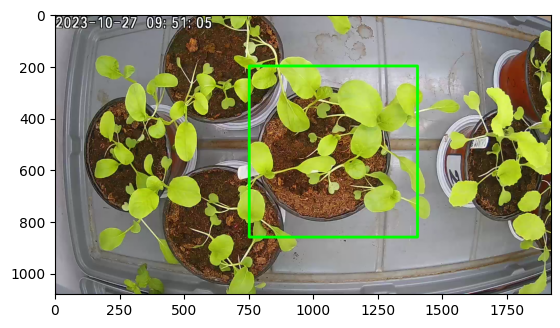

In [110]:
x1, y1, x2, y2 = 750, 200, 1400, 860

image = cv2.imread(new_images_paths[3])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rect = cv2.rectangle(image_rgb.copy(), (x1, y1), (x2, y2), (0,255,0), 10)

image_cropped = image_rgb[y1:y2, x1:x2]
original_size = image_cropped.shape[:2]

plt.imshow(image_rect)

(-0.5, 649.5, 659.5, -0.5)

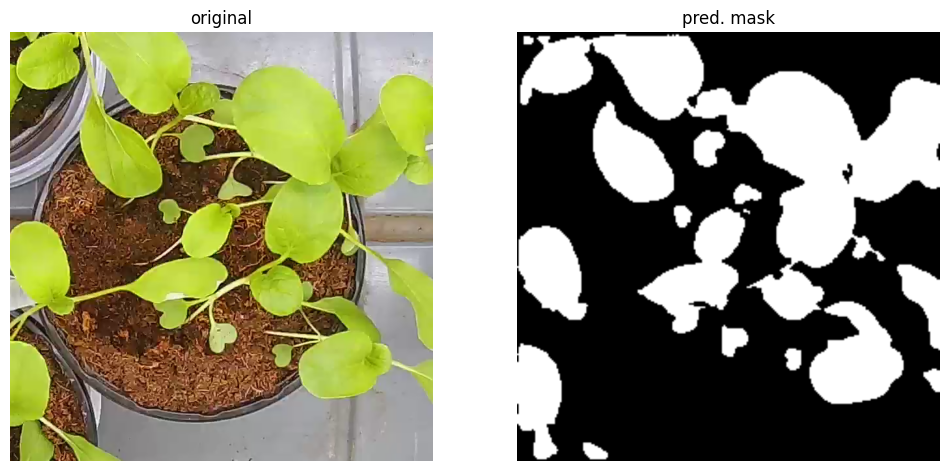

In [111]:
# выбираем модель (по номеру)
model_num = 0

# подготовка изображения для предсказания
image_tensor = strategies[model_num]['dataset']['train'].convert_image_to_input_format(image_cropped)

# чтобы показать - не нужно, можно же оригинал показать
# tv_image = T.ToPILImage()(image_tensor)
# image_np = image_tensor.permute(1, 2, 0).numpy()  # Перестановка осей с CHW на HWC
# image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) # разнормализация обратно ?

model = strategies[model_num]['model_config']['model']
with torch.no_grad():
    outputs = model(image_tensor)
    preds = torch.sigmoid(outputs).round()

pred_mask = strategies[model_num]['dataset']['train'].resize_prediction_to_original(preds[0], original_size)

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].imshow(image_cropped)
axes[0].set_title('original')
axes[0].axis('off')

axes[1].imshow(pred_mask, cmap='gray')
axes[1].set_title('pred. mask')
axes[1].axis('off')

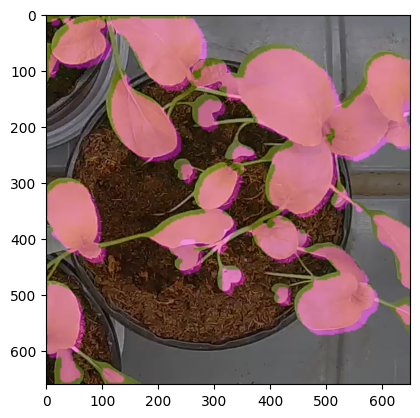

In [127]:


plt.imshow(overlay_mask_on_image(image_cropped, pred_mask))